# Optimizers

In the last few lessons, we learned how to build several neural network architectures.  We used gradient descent, a technique we originally learned in the [dense neural network](https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/dense.ipynb) lesson, to adjust model parameters.

Gradient descent is a type of optimizer.  Optimizers adjust neural network parameters to try to get loss to (hopefully) a global minimum value.  In this lesson, we'll learn more about optimizers.  We'll first go into more depth on gradient descent, and discuss batch size, learning rate schedules, weight decay, and momentum.  We'll then discuss the Adam optimizer, which is a popular optimizer that extends the idea of momentum.  Adam variants are the most popular optimizers for large language models.

## Stochastic Gradient Descent

The type of optimizer we've used so far is called stochastic gradient descent, or SGD.  In SGD, we take a minibatch of training examples, then compute the average gradient across the minibatch.  We then adjust the parameters using this average gradient.

Let's define a three-layer dense neural network, then explore the effect of batch size on our loss over time.  We'll first load in a dataset of house prices.

Each row in this dataset represents a single house.  The predictor columns are:

- `interest`: The interest rate
- `vacancy`: The vacancy rate
- `cpi`: The consumer price index
- `price`: The price of a house
- `value`: The value of a house
- `adj_price`: The price of a house, adjusted for inflation
- `adj_value`: The value of a house, adjusted for inflation

The predictor columns have all been scaled using the scikit-learn `StandardScaler`.  This gives each column a mean of 0 and a standard deviation of 1.  This makes it easier to activate our nonlinearities.

The target column is `next_quarter`, which is the price of the house in three months.  `next_quarter` has been scaled so the minimum value is `0`, and it has been divided by `1000` and rounded to the nearest integer.  This makes the prediction task simpler for our network.

In [1]:
import sys, os
sys.path.append(os.path.abspath('../data'))
from csv_data import HousePricesDatasetWrapper

wrapper = HousePricesDatasetWrapper()
train_data, valid_data, test_data = wrapper.get_flat_datasets()

In [2]:
# Show the train predictors
train_data[0][:2]

array([[ 1.94509048,  1.39642758, -1.52275521, -0.64519476, -0.11676266,
        -0.13891486,  0.8225858 ],
       [ 1.93249288,  1.39642758, -1.49354416, -0.64519476, -0.11676266,
        -0.15597175,  0.80219322]])

In [3]:
# Show the train target
train_data[1][:2]

array([[22.],
       [22.]])

Next, we'll define a single layer of our neural network.  We'll make a few modifications from earlier lessons:

- Instead of directly updating the parameters, we'll return the weight and bias gradients
- We'll add an update method that updates the weights later

This will enable us to swap different optimizers in and out of our network.

In [4]:
import math
import numpy as np

class Dense():
    def __init__(self, input_size, output_size, activation=True, seed=0):
        self.add_activation = activation
        self.hidden = None
        self.prev_hidden = None

        # Initialize the weights.  They'll be in the range -sqrt(k) to sqrt(k), where k = 1 / input_size
        np.random.seed(seed)
        k = math.sqrt(1 / input_size)
        self.weights = np.random.rand(input_size, output_size) * (2 * k) - k

        # Our bias will be initialized to 1
        self.bias = np.ones((1,output_size))

    def forward(self, x):
        # Copy the layer input for backprop
        self.prev_hidden = x.copy()
        # Multiply the input by the weights, then add the bias
        x = np.matmul(x, self.weights) + self.bias
        # Apply the activation function
        if self.add_activation:
            x = np.maximum(x, 0)
        # Copy the layer output for backprop
        self.hidden = x.copy()
        return x

    def backward(self, grad):
        # "Undo" the activation function if it was added
        if self.add_activation:
            grad = np.multiply(grad, np.heaviside(self.hidden, 0))

        # Calculate the parameter gradients
        w_grad = self.prev_hidden.T @ grad # This is not averaged across the batch, due to the way matrix multiplication sums
        b_grad = np.mean(grad, axis=0) # This is averaged across the batch
        param_grads = [w_grad, b_grad]

        # Calculate the next layer gradient
        grad = grad @ self.weights.T
        return param_grads, grad

    def update(self, w_grad, b_grad):
        # Update the weights given an update matrix
        self.weights += w_grad
        self.bias += b_grad

We can then use the `Dense` class to create a 3-layer neural network.  The first layer will take in our predictors and generate `25` hidden features, the second layer combine those features into `10` new features, and the final layer will make a prediction.

In [5]:
layers = [
    Dense(7, 25),
    Dense(25, 10),
    Dense(10, 1, activation=False)
]

We'll define functions that run forward and backward passes across all the layers together.  `forward` will do a full forward pass across all 3 layers, and `backward` will do a full backward pass across all 3 layers.

The backward pass will return the gradients instead of updating the parameters.  We'll use these gradients to update the parameters in our optimizer.

In [6]:
def forward(x, layers):
    # Loop through each layer
    for layer in layers:
        # Run the forward pass
        x = layer.forward(x)
    return x

def backward(grad, layers):
    # Save the gradients for each layer
    layer_grads = []
    # Loop through each layer in reverse order (starting from the output layer)
    for layer in reversed(layers):
        # Get the parameter gradients and the next layer gradient
        param_grads, grad = layer.backward(grad)
        layer_grads.append(param_grads)
    return layer_grads

We'll then define our SGD optimizer, which will take in a set of gradients, and use it to update the network parameters.

The process for SGD is:

- Normalize the gradient by batch size, so that the gradient is the average gradient across the batch (in our case, our bias gradient is already normalized, but the weight gradient is not)
- Multiply the gradient by learning rate
- Multiply the gradient by `-1` so it is subtracted from the parameters in the `update` function

We'll define the optimizer as a class, so we can keep track of hyperparameters like learning rate.  Overriding the `__call__` method will enable us to call the optimizer like a function for ease of use.  We'll inherit from an `Optimizer` class that I've created that will make it easy for us to graph how the optimizer changes the weights over time.

In [7]:
import sys, os
sys.path.append(os.path.abspath("../nnets"))

# Import the optimizer class
from optimizer import Optimizer

In [8]:
class SGD(Optimizer):
    def __init__(self, lr):
        # Store hyperparameters
        self.lr = lr
        super().__init__()

    def __call__(self, layer_grads, layers, batch_size, step):
        # Loop through the layer grads.  Reverse the layers to match the grads (from output backward to input).
        for layer_grad, layer in zip(layer_grads, reversed(layers)):
            w_grad, b_grad = layer_grad

            # Normalize the weight gradient by batch size
            w_grad /= batch_size

            # Calculate the update sizes
            w_update = -self.lr * w_grad
            b_update = -self.lr * b_grad

            # Actually do the update
            layer.update(w_update, b_update)

        # Save the first layer weights to generate a graph later.  This is not part of the SGD algorithm - we're doing it to graph the weight changes.
        self.save_vector(layers)

## Monitoring

We can now write a function to train the network using the SGD optimizer and our data.  Since we'll be testing different batch sizes and optimizers, we want a way to monitor our network and compare different runs to wach other.  So far, we've been using print statements to monitor per-epoch accuracy in our network, which is hard to compare to other runs.

We'll use a tool called [Weights & Biases](https://wandb.ai) to monitor our network.  We can use it to track the loss and accuracy of our network, and compare different runs to each other.  W&B is a free tool, and you can sign up for an account [here](https://wandb.ai).  If you don't want to use W&B, you can also use TensorBoard, but it's harder to setup and use.

We'll start by importing `wandb` and logging in.  We'll also set the `WANDB_SILENT` environment variable to `True`, so that W&B doesn't print out a lot of system messages.

In [9]:
%env WANDB_SILENT=True

import wandb
wandb.login()

env: WANDB_SILENT=True


True

With W&B, we track each training run separately.  W&B will track the loss in each epoch, or anything else we want to keep track of.  It will also render graphs for us, so we can compare different runs against each other.

The key W&B functions are:

- `wandb.init` - This will initialize a new run.  We can use the `config` parameter to pass in run-specific information we want to view.
- `wandb.log` - This will log a dictionary of metrics to the current run.
- `wandb.define_metric` - This will define a metric that we want to track.  You normally don't need to define wandb metrics upfront, but we'll use a custom `step_metric` to ensure that results from runs with different batch sizes line up.

We'll use W&B to log a running training loss, the final training set loss each epoch, and the validation set loss.  We'll also track how long each epoch takes to run.

## The Training Loop

We can now write a function that will train our network using SGD, and log the loss to W&B.  This function will be very similar to training loops that we've written in previous lessons.

We won't do this here, but you usually want to shuffle your training data each epoch to ensure that batch composition changes.  Random shuffling is important when our batch size is greater than `1`.  As we saw earlier, the gradient is averaged across all the examples in a batch.  Random shuffling will put different training examples together each time, allowing the model to see more combinations of gradients.  This reduces overfitting, and improves the generalization of our network.  It can also make SGD converge faster (get to the global minimum error).

In our case, we won't do random shuffling, since the data is time series.  Shuffling can actually cause validation error to increase significantly with time series data.

In [10]:
import time

def training_run(epochs, batch_size, optimizer, train_data, valid_data, name=None):
    # Initialize a new W&B run, with the right parameters
    wandb.init(project="optimizers",
               name=name,
               config={"batch_size": batch_size,
                       "lr": optimizer.lr,
                       "epochs": epochs,
                       "optimizer": type(optimizer).__name__})

    # Setup the metrics we want to track with wandb.  You usually don't need to do this, but we want a custom axis for each metric.
    wandb.define_metric("batch_step") # This will ensure that results from runs with different batch sizes line up
    wandb.define_metric("epoch") # This will ensure that results from runs with different batch sizes line up
    wandb.define_metric("valid_loss", step_metric="epoch") # The step metric is the x-axis scale
    wandb.define_metric("train_loss", step_metric="epoch")
    wandb.define_metric("runtime", step_metric="epoch")
    wandb.define_metric("running_loss", step_metric="batch_step")

    # Setup the layers for the training run
    layers = [
        Dense(7, 25),
        Dense(25,10),
        Dense(10, 1, activation=False)
    ]

    # Split the training and valid data into x and y
    train_x, train_y = train_data
    valid_x, valid_y = valid_data

    for epoch in range(epochs):
        running_loss = 0
        start = time.time() # The start time of our run

        for i in range(0, len(train_x), batch_size):
            # Get the x and y batches
            x_batch = train_x[i:(i+batch_size)]
            y_batch = train_y[i:(i+batch_size)]
            # Make a prediction
            pred = forward(x_batch, layers)

            # Run the backward pass
            loss = pred - y_batch
            layer_grads = backward(loss, layers)

            # Run the optimizer
            step_count = (i + batch_size) // batch_size + epoch * len(train_x) // batch_size
            optimizer(layer_grads, layers, batch_size, step_count)

            # Update running loss
            running_loss += np.mean(loss ** 2)

            batch_idx = i + batch_size # Get the last index of the current batch
            batch_step = batch_idx + epoch * len(train_x)
            # Log running loss.  We multiply by batch size to offset the mean from earlier.
            wandb.log({"running_loss": running_loss / batch_idx * batch_size, "batch_step": batch_step})

        # Calculate and log validation loss
        valid_preds = forward(valid_x, layers)
        valid_loss = np.mean((valid_preds - valid_y) ** 2)
        train_loss = running_loss / len(train_x) * batch_size
        wandb.log({
            "valid_loss": valid_loss,
            "epoch": epoch,
            "train_loss": train_loss,
            "runtime": time.time() - start
        })

    # Mark the run as complete
    wandb.finish()

We can then initialize our hyperparameters and start the run.  We define the optimizer, then pass it into the training loop.

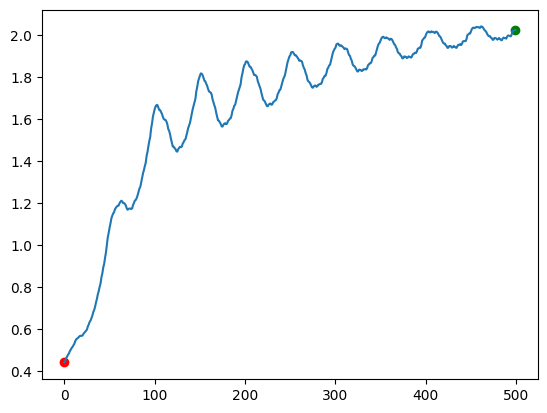

In [11]:
# Setup our parameters
epochs = 10
batch_size = 4
lr = 1e-4

# Run our training loop
sgd = SGD(lr=lr)
training_run(epochs, batch_size, sgd, train_data, valid_data, name="sgd_small")

# Plot the path of the weights over time.
sgd.plot_path()

You should now be able to see your run in W&B.  You will need to click on the `optimizers` project in your [dashboard](https://wandb.ai/home).

You should also see a plot above showing how the singular value of the weight matrix in the last layer changes over time.  The x-axis is time, and the y-axis is the singular value.  The red dot is the starting point, and the green dot is the ending point.

The final weight matrix is `10x1`, so it only has one singular value.  If you're familiar with linear algebra, the singular value is the result of SVD.  If you're not familiar with linear algebra, you can think of the singular value as how much the weights change the inputs to the last layer.  Graphing the singular value tells us how much the weights in the final layer are stretching the inputs in a single direction.

As you can see above, the singular value oscillates a lot over time.  This is because our batch size is small, and the gradients can vary quite a bit from batch to batch.  This is inefficient, since it takes the network more iterations to get to the optimal value.

We'll later be able to compare this graph to the graphs from other optimizers to see how they improve on SGD.

## Batch Size

We can now compare our first run to a run with a higher batch size.  We'll use a batch size of `16`.  We'll increase the number of epochs, to keep the total number of steps the same between runs.  The number of steps is the number of times we run the forward and backward pass.

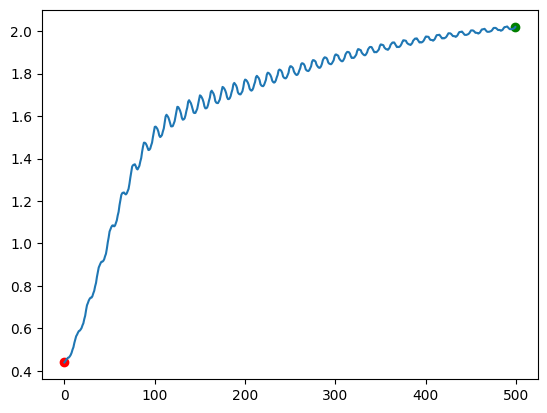

In [12]:
# Setup our parameters
epochs = 40 # higher number of epochs so total steps are equal for comparison purposes
batch_size = 16
lr = 1e-4

# Run our training loop
sgd = SGD(lr=lr)
training_run(epochs, batch_size, sgd, train_data, valid_data, name="sgd_large")
sgd.plot_path()

You should end up with a dashboard that looks like this:

![W&B Dashboard](images/optimizers/wandb_comp2.png)

We can draw a few conclusions from this graph and the graph of our average weights:

1. The higher batch size descends more slowly than a lower batch size
2. The higher batch size converges to a higher training and validation loss
3. The higher batch size runs each epoch much faster
4. A higher batch size has more stable weight updates - the singular value of the weight matrix doesn't get pulled back and forth as much (in the graph)

Batch size can make a big impact on the final accuracy of your model.  In general, a higher batch size is a form of regularization (which we'll talk about in depth in a later lesson).  Regularization increases training loss, but decreases validation loss.  This happens because you're averaging over multiple training examples in the batch, and making it harder to overfit to specific examples.  It may seem counterintuitive, but our goal in training neural networks isn't to get the lowest training loss possible.  It's instead to get the lowest validation loss possible.  This is because we want the model to work well on new data that we feed into it after it's been trained.  Regularization helps the model generalize well to new data.

Higher batch sizes can run much faster than lower batch sizes.  This is because we're just adding rows to existing matrices.  In practice, if the batch size is too high, then validation loss starts to suffer.  So you need to find the batch size that runs quickly and minimizes validation loss.  This is different for each dataset, so it can take some experimentation.

## Momentum

One downside to the basic SGD optimizer is that it has no knowledge of past gradients.  It has to make the decision on how to adjust the parameters based only on the current gradient.  It's like asking you to predict if a stock price will go up or down tomorrow.  If you only know how the stock did today, your guess will be worse than if you know how the stock did over the past year.

We can solve this by keeping track of the stock price over time.  More recent stock prices are more informative than older ones, so we might weight the mean exponentially.  The formula would look like:

$$\text{ema}=\beta \text{ema} + (1-\beta) * \text{price}$$

$\beta$ is the decay coefficient that governs how quickly older values shrink.  $\text{ema}$ is the exponential moving average.

In [13]:
# Initialize a list of random stock prices between 2 and 10
prices = np.random.randint(2,10,10)
prices

array([8, 9, 9, 8, 2, 3, 7, 3, 7, 2])

In [14]:
exp_avg = []
ema = prices[0] # Store the moving average.  Initialize it to the first value.
decay = .5 # How fast the values decay.  The higher this is, the more we care about past values

# Calculate the exponential average
for i in range(prices.shape[0]):
    ema = ema * decay + (1-decay) * prices[i]
    exp_avg.append(ema)
np.vstack((prices, exp_avg))

array([[8.        , 9.        , 9.        , 8.        , 2.        ,
        3.        , 7.        , 3.        , 7.        , 2.        ],
       [8.        , 8.5       , 8.75      , 8.375     , 5.1875    ,
        4.09375   , 5.546875  , 4.2734375 , 5.63671875, 3.81835938]])

As you can see above, the exponential moving average moves around less than the prices.  This is useful when we want to minimize the effect of outliers.

When we apply this to SGD, it is called momentum.  With momentum, we give the optimizer knowledge of the direction the gradient is moving in.  We do this by using an exponential moving average of the history of the gradient.  When we make a parameter update, we combine this exponential moving average with the current gradient value.

The equation for SGD with momentum looks like:

$$
\begin{aligned}
v_t &= \beta v_{t-1} - \alpha \nabla L(w_t) \\
w_{t+1} &= w_t + v_t
\end{aligned}
$$

$v_{t-1}$ is the previous momentum value, $\beta$ is a parameter that controls how quickly the momentum decays, $\alpha$ is the learning rate, and $\nabla L(w_t)$ is the gradient of the loss with respect to the parameter.  We use a slightly different formula from the `ema` formula we used earlier so that the velocity doesn't start out very close to `0` for several iterations (this happens if you multiply the gradient by $(1-\beta)$.

Each iteration, we update the momentum, then combine it with the current gradient.  We then update the parameter based on the combined value.  We say that the momentum exponentially decays since each value added to the velocity will be multiplied by $\beta$ once per update.

Intuitively, this stops the weight value from changing as drastically between iterations.

In [15]:
class SGDMomentum(Optimizer):
    def __init__(self, lr, beta):
        # Store hyperparameters
        self.lr = lr
        self.beta = beta
        # Used to store history of momentum
        self.momentums = None

        super().__init__()

    def initialize_momentums(self, layer_grads):
        self.momentums = []

        # Initialize momentums to have the same shape as the parameters
        for layer_grad in layer_grads:
            w_grad, b_grad = layer_grad
            initial_momentums = [np.zeros_like(w_grad), np.zeros_like(b_grad)]
            self.momentums.append(initial_momentums)

    def __call__(self, layer_grads, layers, batch_size, step):
        if self.momentums is None:
            self.initialize_momentums(layer_grads)

        # Used to store momentums for the next parameter update
        new_momentums = []
        for layer_grad, momentum, layer in zip(layer_grads, self.momentums, reversed(layers)):
            w_grad, b_grad = layer_grad
            w_vel, b_vel = momentum

            # Normalize the weight gradient by batch size
            w_grad /= batch_size

            # Calculate the update sizes
            w_vel = w_vel * self.beta - self.lr * w_grad
            b_vel = b_vel * self.beta - self.lr * b_grad

            layer.update(w_vel, b_vel)
            new_momentums.append([w_vel, b_vel])
        self.momentums = new_momentums
        self.save_vector(layers)

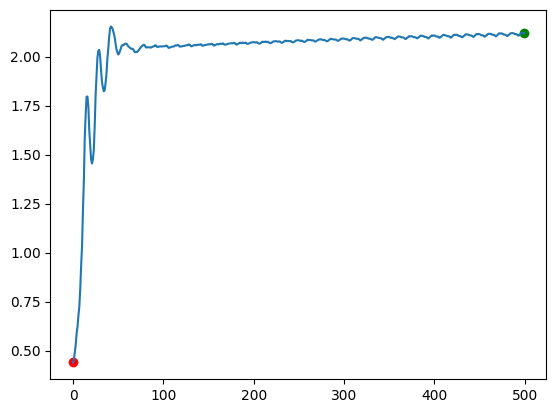

In [16]:
# Setup our parameters
epochs = 40
batch_size = 16
lr = 1e-4
beta = .9

# Run our training loop
sgd = SGDMomentum(lr, beta)
training_run(epochs, batch_size, sgd, train_data, valid_data, name="sgd_momentum")
sgd.plot_path()

When we look at the graph above and the W&B dashboard, we notice a few things about SGD with momentum:

- It descends faster than vanilla SGD
- The train and validation losses end up lower
- The weight updates seem to be more consistent

Momentum can help neural networks avoid local minima, and can improve training efficiency.

## Adam

SGD uses what is called the first moment of the gradient, which is the mean.  It keeps track of a moving average (mean) of the gradient over time.  It doesn't have any information about how different one gradient is from the next.  To know this, we'd have to track the variance, or the second moment of the gradient.  The variance tells us how much the gradient varies across batches.

Adam is an optimizer that extends SGD to use the second moment.  It also corrects the moving average of the first and second moment so that they don't stay close to 0 during the first few iterations.

With Adam, we first calculate the moving average of the first moment $m$ and the second moment $v$.  We now have 2 exponential decay coefficients, $\beta_1$ and $\beta_{2}$:

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
\end{aligned}
$$

Normally, the variance is centered by subtracting the mean before squaring.  In this case, we calculate the uncentered variance, since we don't know the population mean.  We then correct the values, so that they aren't too small in the first few iterations:

$$
\begin{aligned}
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}t &= \frac{v_t}{1 - \beta_2^t}
\end{aligned}
$$

Note that the correct factor is raised to the power $t$, which is the index of the iteration we're on.  This start $1-\beta_1^t$ out at a very low number, then increase it towards `1` as we progress.  This will increase the value of $m_t$ early on, and not change it in later iterations.  This corrects for the fact that the exponential moving averages are initialized with value `0`, which is below the true moving average of the gradient values.

We then update the parameters:

$$
\begin{aligned}
w_{t+1} &= w_t - \alpha\frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}
$$

$\alpha$ is our learning rate, and $\epsilon$ is a small tolerance value to avoid dividing by a number that is too small and will cause numerical instability.  It works lik the tolerance we used in an earlier lesson on softmax.

We can look at an example of how this works by going back to our stock prices:

In [20]:
# Initialize a list of random stock prices between 2 and 10
prices = np.random.randint(2,10,100)

exp_avg = []
exp_var = []

ema = 0 # Store the moving average.  Initialize it to 0.
emv = 0 # Moving variance.

beta1 = .5 # How fast the ema decays.  The higher this is, the more we care about past values
beta2 = .9

# Calculate the first and second moments
for i in range(prices.shape[0]):
    # First moment
    ema = ema * beta1 + (1-beta1) * prices[i]
    ema /= (1 - beta1 ** (i+1)) # this will increase the ema when we're starting out.  Over time, `beta1 ** i` will decrease to close to 0.
    exp_avg.append(ema)

    # Second moment
    emv = emv * beta2 + (1-beta2) * prices[i] ** 2
    emv /= (1 - beta2 ** (i+1))
    exp_var.append(emv)
np.vstack((prices, exp_avg, exp_var))

array([[9.00000000e+00, 9.00000000e+00, 7.00000000e+00, 7.00000000e+00,
        7.00000000e+00, 2.00000000e+00, 3.00000000e+00, 7.00000000e+00,
        3.00000000e+00, 5.00000000e+00, 2.00000000e+00, 9.00000000e+00,
        7.00000000e+00, 8.00000000e+00, 2.00000000e+00, 3.00000000e+00,
        4.00000000e+00, 6.00000000e+00, 4.00000000e+00, 2.00000000e+00,
        7.00000000e+00, 5.00000000e+00, 4.00000000e+00, 4.00000000e+00,
        7.00000000e+00, 2.00000000e+00, 9.00000000e+00, 7.00000000e+00,
        3.00000000e+00, 9.00000000e+00, 2.00000000e+00, 4.00000000e+00,
        4.00000000e+00, 5.00000000e+00, 4.00000000e+00, 9.00000000e+00,
        9.00000000e+00, 5.00000000e+00, 4.00000000e+00, 3.00000000e+00,
        4.00000000e+00, 8.00000000e+00, 5.00000000e+00, 8.00000000e+00,
        5.00000000e+00, 5.00000000e+00, 4.00000000e+00, 8.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 8.00000000e+00, 3.00000000e+00, 4.000000

As you can see above, we keep track of both the mean and the variance.

In [17]:
from copy import deepcopy

class Adam(Optimizer):
    def __init__(self, lr, beta1, beta2, eps, decay):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.decay = decay
        self.moments = None

        super().__init__()

    def initialize_moments(self, layer_grads):
        self.moments = []
        for layer_grad in layer_grads:
            w_grad, b_grad = layer_grad
            moment1 = [np.zeros_like(w_grad), np.zeros_like(b_grad)]
            moment2 = deepcopy(moment1)
            self.moments.append([moment1, moment2])

    def __call__(self, layer_grads, layers, batch_size, step):
        if self.moments is None:
            self.initialize_moments(layer_grads)

        new_moments = []
        for layer_grad, moment, layer in zip(layer_grads, self.moments, reversed(layers)):
            w_grad, b_grad = layer_grad
            moment1, moment2 = moment

            # Normalize the weight gradient by batch size
            w_grad /= batch_size


            corrected_moments = []
            for i, grad in enumerate([w_grad, b_grad]):
                moment1[i] = moment1[i] * self.beta1 + (1 - self.beta1) * grad
                moment2[i] = moment2[i] * self.beta2 + (1 - self.beta2) * np.square(grad)

                corrected_moments.append([
                    moment1[i] / (1 - self.beta1 ** step),
                    moment2[i] / (1 - self.beta2 ** step)
                ])

            w_update = -self.lr * corrected_moments[0][0] / (corrected_moments[0][1] ** .5 + self.eps)
            b_update = -self.lr * corrected_moments[1][0] / (corrected_moments[1][1] ** .5 + self.eps)
            layer.update(w_update, b_update)

            new_moments.append([moment1, moment2])
        self.moments = new_moments
        self.save_vector(layers)

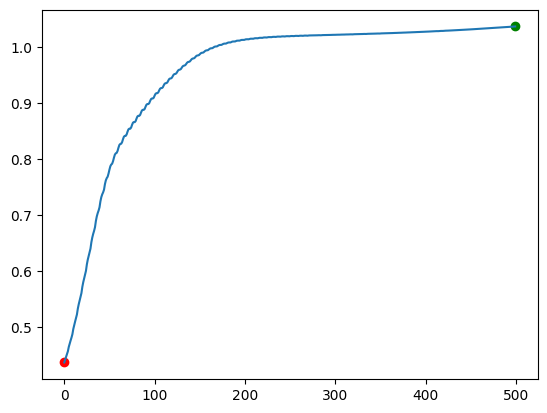

In [18]:
# Setup our parameters
epochs = 80
batch_size = 32
lr = 1e-3

# Run our training loop
adam = Adam(lr, .9, .999, 1e-8, .1)
training_run(epochs, batch_size, adam, train_data, valid_data, name="adam")
adam.plot_path()

As you can see, AdamW can take a higher learning rate than SGD for this dataset.  AdamW tends to converge more predictably than SGD, and is widely used to train LLMs like GPT.

## Learning Rate Schedule

The most important hyperparameter for any optimizer is the learning rate.  The learning rate has a big effect on the performance of a model.  So far, we've used a fixed learning rate that doesn't change during training.

In practice, it's common to use a learning rate scheduler.  A learning rate scheduler changes the learning rate during training.  This helps the model converge, and avoid taking gradient descent steps in the wrong direction.

It's common to alter the learning rate in two ways:

- Set the learning rate low initially as a warmup phase.  This helps to stabilize training, and avoid large gradient steps initially.